# Contents
- [Purpose](#Purpose)
- [Library import](#Library-import)
- [Input params](#Input-params)
- [Function definitions](#Function-definitions)
- [Radius of influence](#Radius-of-influence)
- [Probability distribution](#Probability-distribution)
- [Quality flag info](#Quality-flag-info)
- [Comparison between PY and DCT](#Comparison-between-PY-and-DCT)

***

# Purpose
[Return to the "Table of contents"](#Contents)

Reproduces the figures in the manuscript "https://doi.org/10.3390/rsxxxx" for the SGLI/GCOM-C.  
Including the comparison of the remapping results from PY and DCT.

# Library import   

[Return to the "Table of contents"](#Contents)

Import all required modules below for the Level-2 resampling.  

---

In [1]:
!pip install netcdf4 pyresample gdal h5py pyproj matplotlib

Clone the resampling repository.  
It contains sample data and Python scripts for file IO

In [2]:
import os
import subprocess
import time
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import pyproj
from cartopy import feature as cfeature, crs as ccrs
from osgeo import gdal

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

In [3]:
%matplotlib inline

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Local imports

In [5]:
import sys
sys.path.append('utils')

In [6]:
import utils
from utils.swathresample import SwathResample

# Input params
[Return to the "Table of contents"](#Contents)

Define the input file (netCDF4 or HDF5), output projection for the GeoTIFF file and the area id.  
We can also define here the [Google cloud bucket](https://cloud.google.com/storage/docs/gsutil), the [Earth Engine Asset](https://developers.google.com/earth-engine/guides/asset_manager).  The EE asset is where GeoTIFF file is uploaded to.

---

Sample file (SGLI)

In [7]:
# Smaple SGLI/GCOM-C files
INPUT_FILE = Path('sample_data/GC1SG1_202205030152F05810_L2SG_IWPRQ_3000.h5')
# Target projection
PROJ_NAME = 'laea'
# Projection area ID
# Output Path
OPATH = Path('result').absolute()
if not OPATH.is_dir():
    OPATH.mkdir(parents=True)
# GeoTIFF output
TRG_TIFF = OPATH.joinpath('GC1SG1_202205030152F05810_L2SG_OC_3000.tif')
# projection id
AREA_ID = 'nowpap_region'

# Function definitions
[Return to the "Table of contents"](#Contents)

Operations with Level-2 file 
`SwathResmaple` contains the following helper functions
1. `SwathResmaple.resample` - for swath resampling, accepts, data, cutoff and sequence number
2. `SwathResmaple.scale` - for data scaling into integer, accepts data and varname
3. `SwathResmaple.open` - open a new GeoTIFF file in write mode, accepts number os bands
4. `SwathResmaple.append` - append var(i) in the opened GeoTIFF, accept band sequence number and varname
5. `SwathResmaple.translate` - GDAL translate the created GeoTIFF
6. `SwathResmaple.close` - closes file, both netCDF4/HDF5 and GeoTIFF

In [8]:
with SwathResample(INPUT_FILE, trg_tif=TRG_TIFF, srs=PROJ_NAME, area_id=AREA_ID) as fid:
    
    # get the spatial resolution from file metadata
    roi = fid.spatial_resolution()
    print(f'SpatialResolution: {roi}')
    # in the case of SGLI pass two files, since CHL and Rrs are in separate files
    
    lon, lat = fid.target_geo.get_lonlats()      
    attrs = fid.glob_attrs
    flag_names = fid.get_flag_names()
    
    result = {'slon': fid.lon, 'slat': fid.lat,
              'mlon': lon, 'mlat': lat, 
              'clon': fid.clon, 
              'clat': fid.clat}
    update = result.update
    
    for i, key in enumerate(fid.get_keys()):
        if key not in ('chlor_a', 'CHLA', 
                       'l2_flags', 'QA_flag'):
            continue
        # Read data from file
        sds = fid.get_data(key=key)
        
        # Pyresample, use twice the resolution. 
        # we compare between using the original and 2x the resolution
        res = fid.resample(data=sds, i=i, roi=roi*2, key=key)
        update({f's{key}': sds, f'm{key}': res})
        
        if key in ('chlor_a', 'CHLA'):
            res = fid.resample(data=sds, i=i, roi=roi, key=key)
            update({f'm{key}_r': res})
print('done..!')

Rounding shape to (8621, 8040) and resolution from (251.0, 251.0) meters to (250.99112192356145, 250.97432778700153) meters


SpatialResolution: 250.0
	 1:      CHLA | Elapsed 42.483 sec
	 1:      CHLA | Elapsed 49.117 sec
	 2:   QA_flag | Elapsed 45.782 sec
done..!


# Radius of influence
## Compare swath vs. mapped

[Return to the "Table of contents"](#Contents)

SGLI maps are much bigger since they are 250 m spatial resolution.   
We can always subset to focus only on the region of interest. 

In [9]:
def subset(xq, yq, bbox):
    idx = np.where((xq >= bbox[0]) & 
                   (xq <= bbox[2]) &
                   (yq >= bbox[1]) & 
                   (yq <= bbox[3]))
    sy = slice(idx[0].min(), idx[0].max() + 1)
    sx = slice(idx[1].min(), idx[1].max() + 1)
    return sx, sy

Label: Centre
Label: Edge
Wall time: 8min 56s


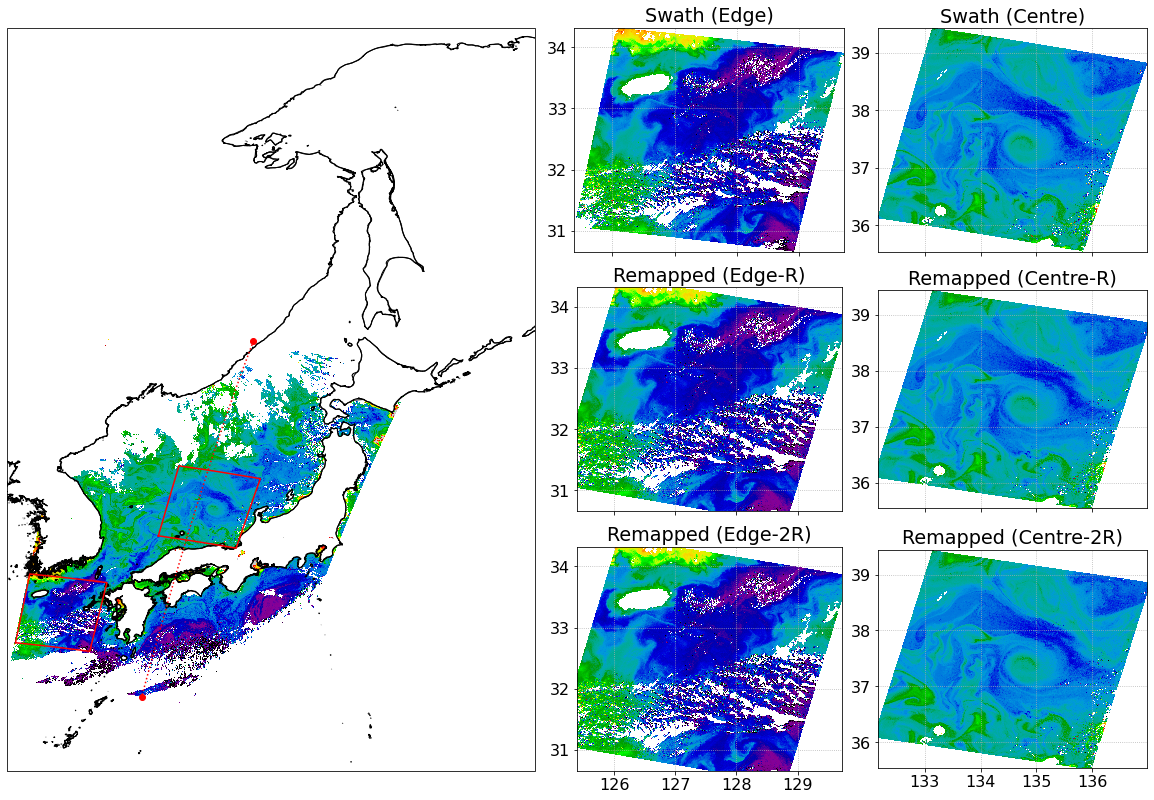

In [10]:
%%time

utils.update_rc_params(figsize=(16, 11), 
                       constrained_layout=True)
# map extent 
extent = 125, 150, 25, 60

# near center vs near edge
fig = plt.figure()
gs = gridspec.GridSpec(3, 4, figure=fig)

axm = fig.add_subplot(gs[:, :2], projection=ccrs.PlateCarree())

ax0 = fig.add_subplot(gs[0, -2])
ax1 = fig.add_subplot(gs[1, -2])
ax2 = fig.add_subplot(gs[2, -2])

ax3 = fig.add_subplot(gs[0, -1])
ax4 = fig.add_subplot(gs[1, -1])
ax5 = fig.add_subplot(gs[2, -1])
axs = (ax3, ax4, ax5), (ax0, ax1, ax2)
bounds = (133, 36, 136, 39), (126, 31, 129, 34)

axm.coastlines()
axm.add_feature(cfeature.GSHHSFeature(scale='f'))
axm.set_extent(extent)
norm = LogNorm(vmin=0.09, vmax=10)
axm.pcolormesh(result['slon'], result['slat'], 
               result['sCHLA'], cmap='nipy_spectral', 
               norm=norm, shading='auto')
axm.plot(result['clon'], result['clat'], ':r')
axm.plot(result['clon'][0], result['clat'][0], marker='o', color='r')
axm.plot(result['clon'][-1], result['clat'][-1], marker='o', color='r')

for bbox, ax, label in zip(bounds, axs, ('Centre', 'Edge')):
    print(f'Label: {label}')
    # Data within this bbox
    sx, sy = subset(xq=result['slon'], 
                    yq=result['slat'], bbox=bbox)
    ncx = result['slon'][sy, sx]
    ncy = result['slat'][sy, sx]
    sample0 = result['sCHLA'][sy, sx]
    flags0 = result['sQA_flag'][sy, sx]
    
    # -------------
    # swath polygon
    # -------------
    px, py = utils.descending_polygon(xv=ncx, yv=ncy)
    # Save polygon 
    utils.save_shape(px, py, file=OPATH.joinpath(f'sgli_{label.lower()}.shp'))
    
    axm.plot(px, py, '-r')
    ax[0].pcolormesh(ncx, ncy, sample0, shading='auto',
                     norm=norm, cmap='nipy_spectral')
    ax[0].set_title(f'Swath ({label})')
    
    bbx = np.min(px)-.5, np.min(py)-.5, np.max(px)+.5, np.max(py)+.5
    sx, sy = subset(xq=result['mlon'], yq=result['mlat'], bbox=bbx)
    mpx = result['mlon'][sy, sx]
    mpy = result['mlat'][sy, sx]
    extent = np.min(mpx), np.max(mpx), np.min(mpy), np.max(mpy)
    # ------------------------
    # resampled with R and 2*R
    # ------------------------
    sample1 = result['mCHLA'][sy, sx] # 2*R (default)
    sample2 = result['mCHLA_r'][sy, sx] # R
    flags1 = result['mQA_flag'][sy, sx]

    # ------------------------------------
    # Mapped data within the swath polygon
    # ------------------------------------
    inpoly = utils.inpolygon(xq=mpx, yq=mpy, xv=px, yv=py)
    sample1 = np.ma.masked_where(~inpoly, sample1)
    sample2 = np.ma.masked_where(~inpoly, sample2)
    
    ax[1].imshow(sample2, extent=extent, norm=norm, 
                 cmap='nipy_spectral', 
                 interpolation='nearest')
    ax[1].set_title(f'Remapped ({label}-R)')
    ax[2].imshow(sample1, extent=extent, norm=norm, 
                 cmap='nipy_spectral', 
                 interpolation='nearest')
    ax[2].set_title(f'Remapped ({label}-2R)')
    
    for k, axi in enumerate(ax):
        axi.set_xlim([np.min(px), np.max(px)])
        axi.set_ylim([np.min(py), np.max(py)])
        axi.grid(True, axis='both')
        if bbox[0] == 133:
            axi.set_xticks((133, 134, 135, 136))
            axi.set_yticks((36, 37, 38, 39))
        if bbox[0] == 127:
            axi.set_xticks((127, 128, 129, 130))
            axi.set_yticks((31, 32, 33, 34))
        if k != 2:
            axi.set_xticklabels([])
fname = INPUT_FILE.name.replace(INPUT_FILE.suffix, '_swath_mapped.png')
fig.savefig(OPATH.joinpath(fname), dpi=300)

# Probability distribution 

## Compare swath vs. remapped

[Return to the "Table of contents"](#Contents)

Remapped has more pixels than swath due to decrease in spatial resolution towards swath edge

In [11]:
def ax_lim(ax, inset=True):
    if inset:
        ax.set_xlim(np.log10((0.02, 5.1)))
        ax.set_xticks(np.log10((0.03, 0.1, 0.3, 1, 3)))
        ax.set_ylim(ax.get_ylim())
        ax.set_yticks((1, 2, 3))
        ax.set_ylabel("")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.get_legend().remove()
        return
    
    ax.set_xticks(np.log10((0.03, 0.1, 0.3, 1, 3)))
    ax.set_xticklabels((0.03, 0.1, 0.3, 1, 3))
    ax.set_xlim(np.log10((0.02, 5.1)))
    ax.set_yticks((1, 2, 3))
    ax.set_ylim(0, 3.1)

- Get the histograms for the swath vs. remapped image

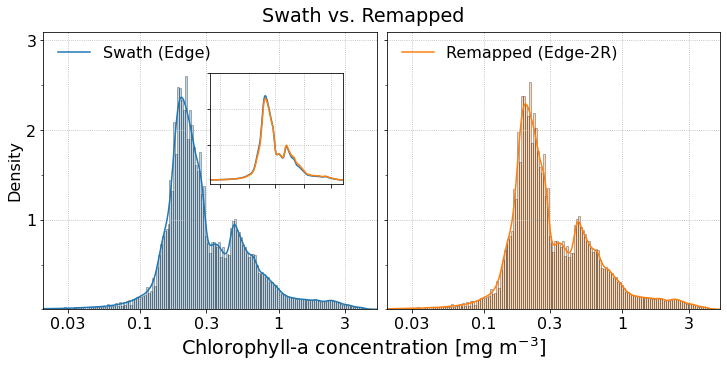

In [12]:
utils.update_rc_params(constrained_layout=True, figsize=(10, 5))
fig, axs = plt.subplots(1, 2, sharey='all')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

density = True
# -----------
# mapped data
# -----------
hist1 = np.ma.log10(sample1)
hist1 = np.ma.compressed(hist1)
dist = pd.DataFrame([], index=range(hist1.size),
                    columns=['Swath (Edge)', 'Remapped (Edge-2R)'])
dist['Remapped (Edge-2R)'] = hist1

# -----
# swath
# -----
hist_size = int(sample0.shape[1]/3)
hist0 = np.ma.compressed(np.ma.log10(sample0))
# remapped has more pixels (higher resolution)
loc = np.bool_(np.zeros((hist1.size,)))
loc[:hist0.size] = True
dist.loc[loc, 'Swath (Edge)'] = hist0

zipped = zip(axs, ('Swath (Edge)', 'Remapped (Edge-2R)'), (hist0, hist1))
for k, (ax, lab, data) in enumerate(zipped):
    ax.hist(data, hist_size, density=density, 
            ec='k', fc=colors[k], alpha=0.3)
    dist[lab].plot.kde(ax=ax, legend=False, color=colors[k])
    ax_lim(ax, inset=False)
    ax.legend(frameon=False, loc='upper left')

axins = axs[0].inset_axes([0.5, 0.45, 0.4, 0.4])
dist.plot.kde(ax=axins)
ax_lim(axins, inset=True)

fig.suptitle('Swath vs. Remapped')
fig.supxlabel('Chlorophyll-a concentration [mg m$^{-3}$]')
axs[0].set_ylabel('Density')

fname = INPUT_FILE.name.replace(INPUT_FILE.suffix, '_chl_prob.png')
fig.savefig(OPATH.joinpath(fname), dpi=300)

- Statistics of the swath vs. remapped (PY) images.

In [13]:
hist2 = np.ma.compressed(np.ma.log10(sample2.flatten()))
# mapped has more pixels
loc = np.bool_(np.zeros((hist1.size,)))
loc[:hist2.size] = True
dist.loc[loc, 'Remapped (R)'] = hist2

desc = dist.astype(float).describe()
index = desc.index
desc.loc[index[1:], :] = 10**desc.loc[index[1:], :]
desc

,Swath (Edge),Remapped (Edge-2R),Remapped (R)
count,1313197.000,1720520.000,1720520.000
mean,0.293,0.307,0.307
std,2.082,2.118,2.118
min,0.002,0.002,0.002
25%,0.190,0.194,0.194
50%,0.246,0.254,0.254
75%,0.458,0.483,0.483
max,89.963,89.963,89.963


# Quality flag info 

## Compare swath vs. remapped

[Return to the "Table of contents"](#Contents)

Remapped has more pixels than swath due to decrease in spatial resolution towards swath edge

In [14]:
def get_flags(array, size):
    ar = np.asarray(
        array).flatten().astype(array.dtype)
    n = ar.size
    r = np.empty((size, n), dtype=int)
    for bit in range(size):
        shift = (1 << bit) & ar
        r[bit, :] = shift > 0
    return r

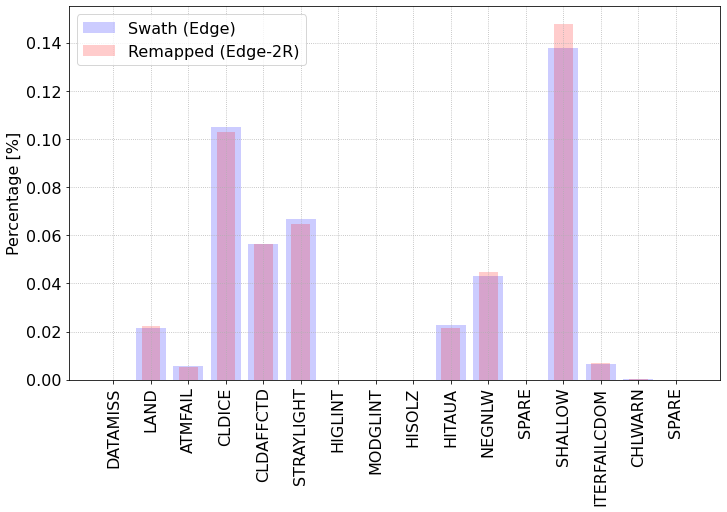

In [15]:
utils.update_rc_params(constrained_layout=True, 
                       figsize=(10, 7))
fig, ax = plt.subplots()

# --------
# l2_flags
# --------

# flags in each pixel
bits0 = get_flags(array=flags0, size=16)
# count
found0 = bits0.sum(axis=1) / flags0.size
bins = np.arange(0, 16)

ax.bar(bins, height=found0, label='Swath (Edge)', fc='b',
       align='center', width=0.8, bottom=0, alpha=0.2)
bits1 = get_flags(array=flags1[inpoly], size=16)
found1 = bits1.sum(axis=1) / flags1[inpoly].size

ax.bar(bins, height=found1, label='Remapped (Edge-2R)', fc='r',
       align='center', width=0.5, bottom=0, alpha=0.2)

ax.legend()
ax.set_xticks(bins)

ax.set_xticklabels(flag_names)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Percentage [%]')

fname = INPUT_FILE.name.replace(INPUT_FILE.suffix, f'_flags_dist.png')
fig.savefig(OPATH.joinpath(fname), dpi=300)

# Comparison between PY and [DCT](https://gportal.jaxa.jp/gpr/information/tool?lang=en)

- **Equirectangular Projection**

[Return to the "Table of contents"](#Contents)

Mapped has more pixels than swath due to decrease in spatial resolution towards swath edge

In [16]:
def get_geotiff_dset(file):
        
    ds = gdal.Open(str(file), gdal.GA_ReadOnly)
    band = ds.GetRasterBand(1)
    meta = band.GetMetadata()
    sds = band.ReadAsArray()
    novalue = band.GetNoDataValue()
    if novalue is None:
        novalue = 65535
    
    sds = np.ma.masked_where(sds == novalue, sds)
    if 'valid_min' in meta.keys():
        mnv = float(meta['valid_min'])
        sds = np.ma.masked_where(sds < mnv, sds)
    if 'valid_max' in meta.keys():
        mxv = float(meta['valid_max'])
        sds = np.ma.masked_where(sds > mxv, sds)

    gt = ds.GetGeoTransform()
    sx, px = gt[0], gt[1]
    sy, py = gt[3], gt[5]
    dx, dy = px / 2, py / 2
    height, width = sds.shape
    
    x = np.arange(sx, (sx - dx) + px * width, px)
    y = np.arange(sy, (sy - dy) + py * height, py)

    return x, y, sds

- Probability density function

In [17]:
def get_dist_prob(sds0, sds1, name, label='Swath'):
    utils.update_rc_params(constrained_layout=True, figsize=(10, 5))
    fig, axs = plt.subplots(1, 2, sharey='all')
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    density = True
    # -----------
    # mapped data
    # -----------
    hist1 = np.ma.log10(sds1)
    hist1 = np.ma.compressed(hist1)
    dist = pd.DataFrame([], index=range(hist1.size),
                        columns=[f'{label} (Edge)', 'Remapped-DCT (Edge)'])
    dist['Remapped-DCT (Edge)'] = hist1
    
    hist0 = np.ma.compressed(np.ma.log10(sds0))
    # mapped has fewer pixels (higher resolution)
    loc = np.bool_(np.zeros((hist1.size,)))
    loc[:hist0.size] = True
    dist.loc[loc, f'{label} (Edge)'] = hist0

    zipped = zip(axs, (f'{label} (Edge)', 'Remapped-DCT (Edge)'), (hist0, hist1))
    for k, (ax, lab, data) in enumerate(zipped):
        ax.hist(data, hist_size, density=density, 
                ec='k', fc=colors[k], alpha=0.3)
        dist[lab].plot.kde(ax=ax, legend=False, color=colors[k])
        ax_lim(ax, inset=False)
        ax.legend(frameon=False, loc='upper left')

    axins = axs[0].inset_axes([0.5, 0.45, 0.4, 0.4])
    dist.plot.kde(ax=axins)
    ax_lim(axins, inset=True)
    
    suptitle = f'{label} vs. Remapped'
    if suptitle == 'Remapped vs. Remapped':
        suptitle = 'Remapped (PY vs. DCT)'
    fig.suptitle(suptitle)
    fig.supxlabel('Chlorophyll-a concentration [mg m$^{-3}$]')
    axs[0].set_ylabel('Density')

    fname = INPUT_FILE.name.replace(INPUT_FILE.suffix, name)
    fig.savefig(OPATH.joinpath(fname), dpi=300)

- Read the GeoTIFF and get data and geo-loc information
> The geoloca info is used to extract the polygon data to compare with swath and PY.

In [18]:
eqr = Path(r'result\GC1SG1_202205030152F05810_L2SG_IWPRQ_3000_CHLA.tif')
lon, lat, data = get_geotiff_dset(eqr)

if len(lon.shape) == 1:
    lon, lat = np.meshgrid(lon, lat)
    print(f'Data: {data.shape} | Lon: {lon.shape}')

bbx = np.min(px)-.5, np.min(py)-.5, np.max(px)+.5, np.max(py)+.5
sx, sy = subset(xq=lon, yq=lat, bbox=bbx)
lon, lat, data = lon[sy, sx], lat[sy, sx], data[sy, sx]

Data: (9320, 11132) | Lon: (9320, 11132)


- Extract polygon data

In [19]:
%%time
inpoly = utils.inpolygon(xq=lon, yq=lat, xv=px, yv=py)

Wall time: 4min 46s


- Compare DCT remapping with original swath data

Wall time: 4min 31s


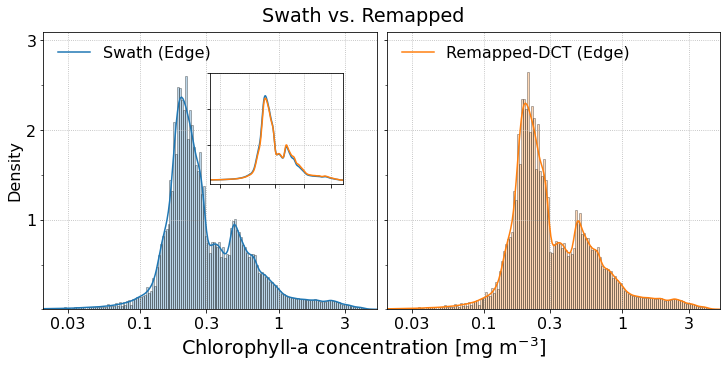

In [20]:
%%time
label = 'Swath'
sf = 0.001600 # scale_factor of the diginal number
name = f'_chl_prob_eqr_{label}.png'
dct = np.ma.masked_where(~inpoly, data)
get_dist_prob(sds0=sample0, sds1=dct * sf, name=name, label=label)

- Now the DCT vs. PY

Wall time: 4min 56s


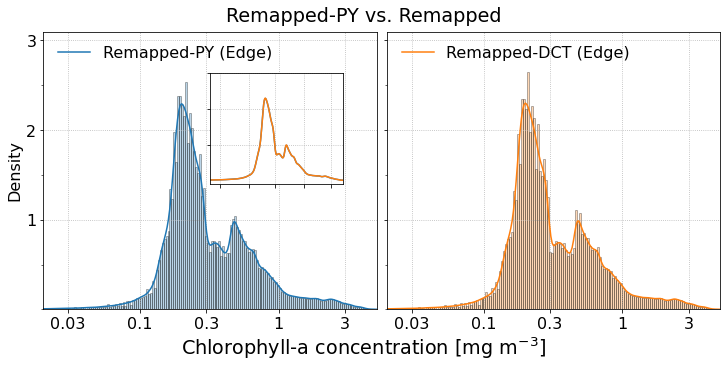

In [21]:
%%time
label = 'Remapped-PY'
name = f'_chl_prob_eqr_{label}.png'
get_dist_prob(sds0=sample1, sds1=dct * sf, name=name, label=label)

- Statistics of the swath and the two remapping procedures.

In [22]:
hist2 = np.ma.compressed(np.ma.log10((dct * sf).flatten()))

dist = pd.DataFrame([], index=range(hist2.size),
                    columns=['Swath (Edge)', 'DCT',
                             'Remapped (Edge-2R)',])
dist['DCT'] = hist2

hist1 = np.ma.log10(np.ma.compressed(sample1))
loc = np.bool_(np.zeros((hist2.size,)))
loc[:hist1.size] = True
dist.loc[loc, 'Remapped (Edge-2R)'] = hist1

hist0 = np.ma.compressed(np.ma.log10(sample0))
# remapped has more pixels (higher resolution)
loc = np.bool_(np.zeros((hist2.size,)))
loc[:hist0.size] = True
dist.loc[loc, 'Swath (Edge)'] = hist0

desc = dist.astype(float).describe()
index = desc.index
desc.loc[index[1:], :] = 10**desc.loc[index[1:], :]
desc

,Swath (Edge),DCT,Remapped (Edge-2R)
count,1313197.000,2397699.000,1720520.000
mean,0.293,0.308,0.307
std,2.082,2.118,2.118
min,0.002,0.002,0.002
25%,0.190,0.194,0.194
50%,0.246,0.254,0.254
75%,0.458,0.483,0.483
max,89.963,104.854,89.963


- Difference between the PY and DCT
> Note that the data in "sgli_py_dct_diff_table.csv" is downloaded from GEE from the ingested files.  
> The Y-scale is logarithmic to highlight the small count values 

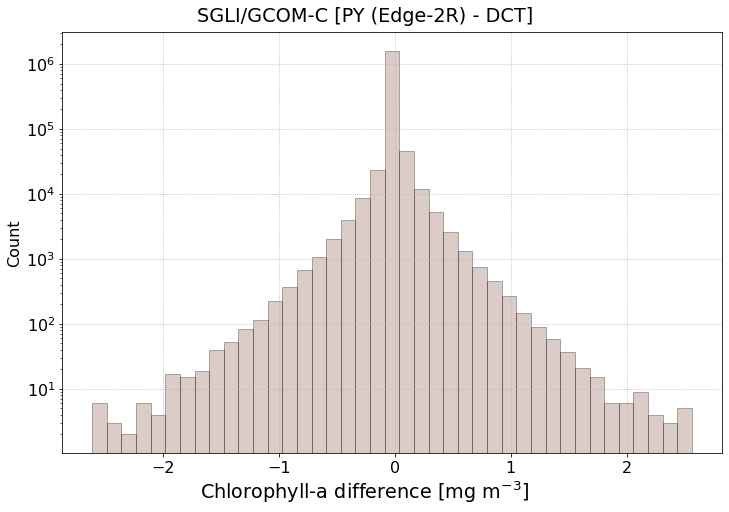

In [23]:
diff_hist = pd.read_csv(r'result\sgli_py_dct_diff_table.csv')
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(figsize=(10, 7))
n, bins, patches = ax.hist(diff_hist['CHLA'], bins=41, 
                           density=False, log=True, cumulative=False,
                           ec='k', fc=colors[5], alpha=0.3)

fig.suptitle('SGLI/GCOM-C [PY (Edge-2R) - DCT]')
fig.supxlabel('Chlorophyll-a difference [mg m$^{-3}$]')
ax.set_ylabel('Count')
fig.savefig(r'result\sgli_py_dct_diff_table.png', dpi=300)